In [88]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorboard as tb
from tensorflow import keras
from keras import datasets, layers, models, Input, Model, activations
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import scipy


In [89]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)



In [90]:
LABEL_KEY = 'open'
activity_df = pd.read_csv("Data/activity.csv", index_col=0)
print(activity_df['data_batch_name'].value_counts())
activity_df = activity_df[activity_df['data_batch_name'].isin(["Genomic"])]


# Enhancer:Open - Inactive:Closed
activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Open' if x in ['StrongEnhancer','WeakEnhancer'] else 'Closed')
test_df = activity_df[activity_df['activity_bin'] != 'Silencer']
groups = [['Inactive'],['Enhancer']]

# Silencer:Open - Inactive:Closed 
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Open' if x == 'Silencer' else 'Closed')
# test_df = activity_df[activity_df['activity_bin'].isin(['Silencer','Inactive'])]
# groups = [['Inactive'],['Silencer']]

# Enhancer+Silencer:Open - Inactive:Closed
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Closed' if x=='Inactive' else 'Open')
# test_df = activity_df
# groups = [['Inactive'],['Enhancer','Silencer']]

# Enhancer:Open - Silencers:Closed
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Closed' if x=='Silencer' else 'Open')
# test_df = activity_df[activity_df['activity_bin'] != 'Inactive']
# groups = [['Silencer'],['Enhancer']]

# test_df = activity_df[(activity_df['activity_bin'] != 'Silencer') & (activity_df['expression_log2'] >0)]


x_test = one_hot_seqs(test_df['sequence'])
encoder = LabelEncoder()
encoder.fit(test_df[LABEL_KEY])
classes = encoder.classes_
num_classes = len(classes)
y_test = encoder.transform(test_df[LABEL_KEY])
y_test = keras.utils.to_categorical(y_test, num_classes)


data_batch_name
Round4a              59645
NOT_TRAINING_DATA    14650
Round4b              11169
Round3b               7526
Round3c               6183
Genomic               4658
Round3a               4438
CrxMotifMutant        4221
Round2                3820
HighConfidence        2054
Name: count, dtype: int64


In [91]:
# classes, encoder.transform(classes), test_df[LABEL_KEY].value_counts()


In [92]:
best_model = keras.models.load_model(os.path.join('ATAC7_164_10663735','5','cnn_model.keras'))

In [93]:

results = best_model.evaluate(x_test,y_test,batch_size=128, verbose=1)

predictions_ = best_model.predict(x_test, verbose=1)

124/124 [==============================] - 2s 13ms/step


In [94]:
# entropies = [scipy.stats.entropy(p) for p in predictions_]
# expression = test_df['expression_log2'].values

In [95]:
truths = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions_, axis=1)

In [96]:
print(classification_report(truths,predictions,target_names=classes))
report = classification_report(truths,predictions,target_names=classes, output_dict=True)


              precision    recall  f1-score   support

      Closed       0.41      0.24      0.31      1454
        Open       0.64      0.79      0.71      2491

    accuracy                           0.59      3945
   macro avg       0.53      0.52      0.51      3945
weighted avg       0.56      0.59      0.56      3945



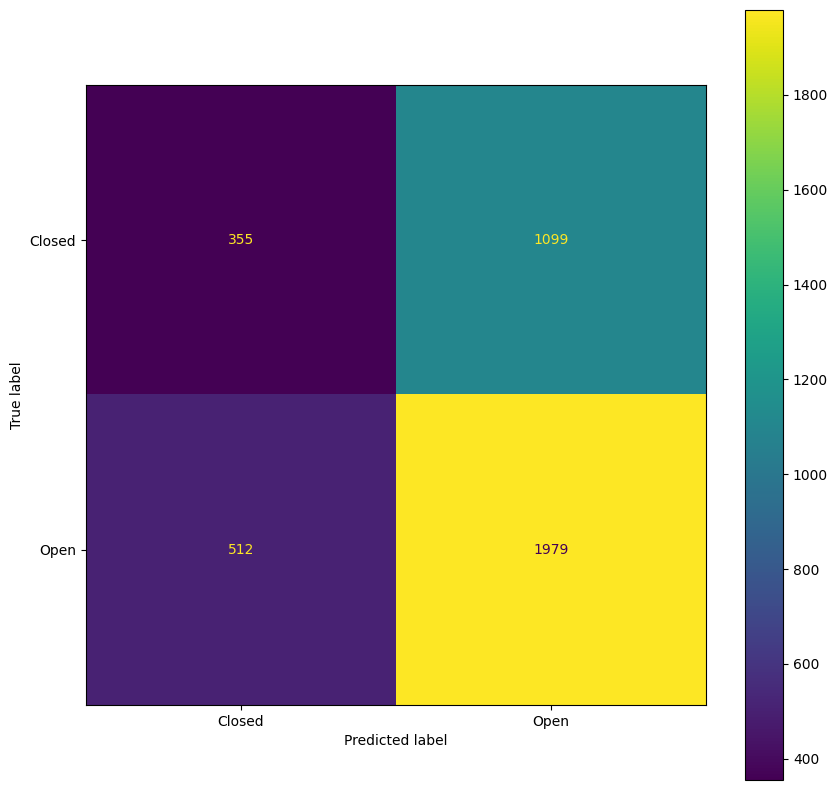

In [97]:
ConfusionMatrixDisplay.from_predictions(truths,predictions,display_labels=classes)

In [98]:
open_close = [[0,0],[0,0]]

for i in range(len(truths)):
    open_close[truths[i]][predictions[i]] += 1


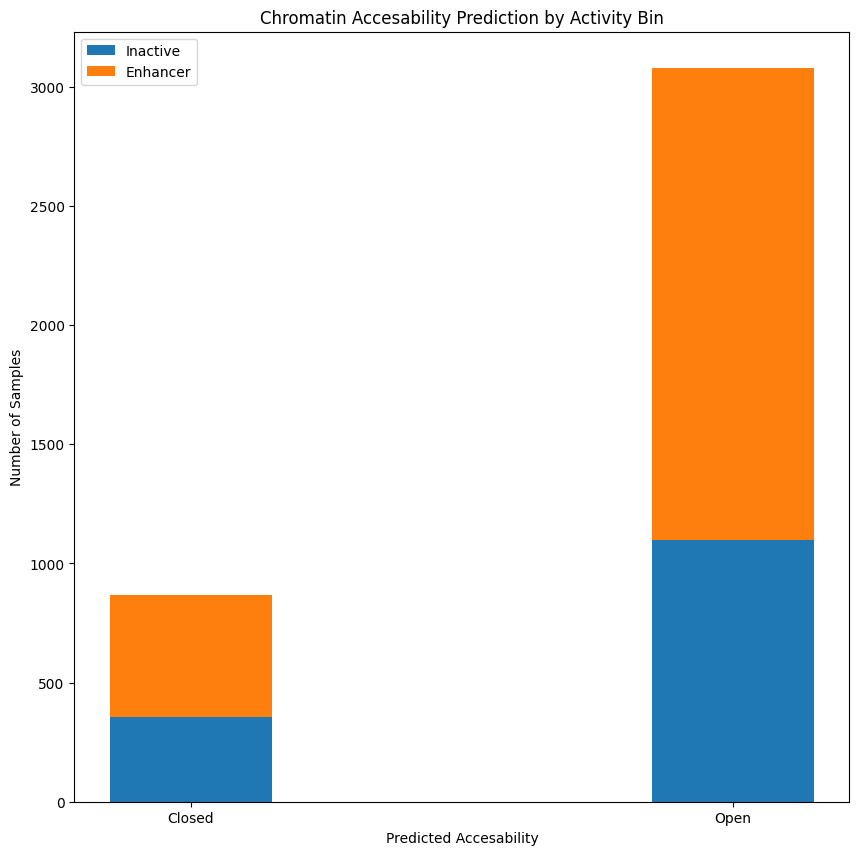

In [99]:

bottom = np.zeros(2)
x = classes

fig, ax = plt.subplots()

for i in range(2):
    ax.bar(x, open_close[i], width=0.3, label="+".join(groups[i]), bottom=bottom)
    bottom += open_close[i]
plt.legend()
plt.ylabel("Number of Samples")
plt.xlabel("Predicted Accesability")
plt.title("Chromatin Accesability Prediction by Activity Bin")

plt.show()


In [100]:
#print(classification_report(truths,predictions,target_names=classes))
# report1 = classification_report(truths,predictions,target_names=classes, output_dict=True)
# report1 = report1['weighted avg']

KeyError: 'precision'

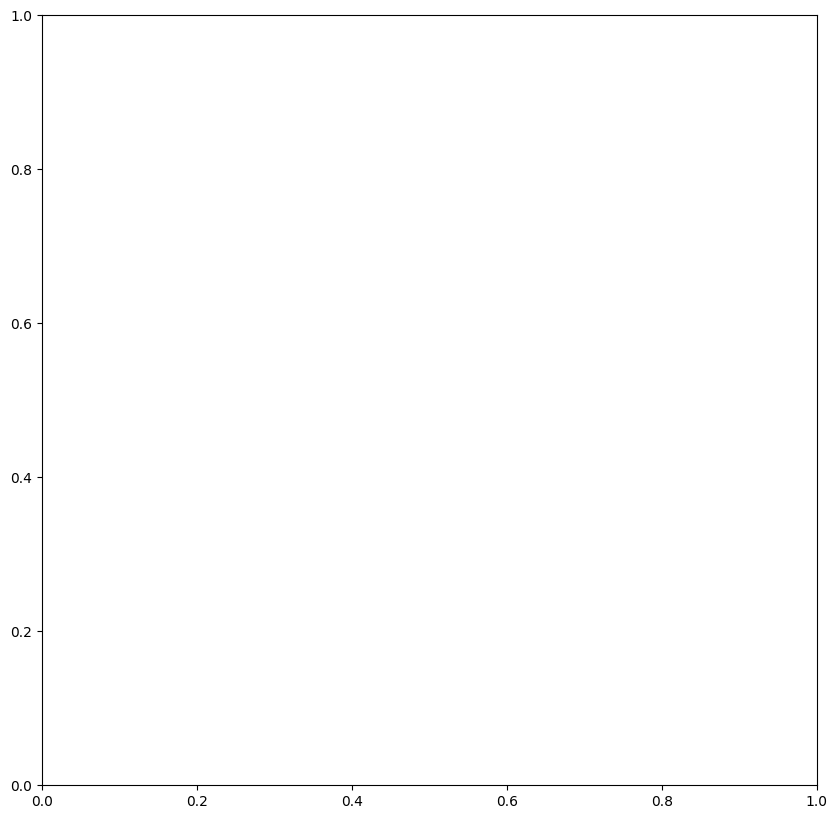

In [101]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots()

report['test'] = 0.5
report1['test']=0.5

reports = [report, report1]

width = 0.15
sep = [-2,-1,0,1]
metrics = ['precision','recall','f1-score', 'test']
for i in range(len(metrics)):
    
    ax.bar(
        x=np.arange(len(reports))+width*sep[i],
        height = [r[metrics[i]] for r in reports],
        width=width,
        label = metrics[i],
        align='center'
    )
    
plt.xticks(ticks = np.arange(len(reports)), labels=['hi\n178','hello'])

# ax.bar(
#     x=np.arange(len(reports))-0.2,
#     height=[r['precision'] for r in reports],
#     width=0.2,
# )
# ax.bar(
#     x=np.arange(len(reports))+0.2,
#     height=[r['recall'] for r in reports],
#     width=0.2,
# )
    
plt.show()
    
    
    